In [2]:
import json
import re
import os

# log.txt to result.json

In [ ]:
with open('./log.txt', 'r') as f:
    text = f.read()

In [ ]:
sample = text

In [ ]:
result = []

for qa in text.split('instruction['):
    if qa == '':
        continue

    [q, a] = qa.split('\noutput[')[:2]
    q = ': '.join(q.split(': ')[1:]).rstrip()
    a = ': '.join(a.split(': ')[1:]).rstrip()
    if(len(a) > 0):
        a = a.split('ERROR')[0]
        a = a.strip('\n')
        if a[-1] == '"':
            a = a[1:-1]
    
    if(len(q) == 0) or (len(a) == 0):
        continue
    result.append({
        'query' : q,
        'topic' : a,
        'rouge' : 0.0,
        'simCSE' : 0.0
    })

In [ ]:
with open('./result_simple.json', 'w') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [ ]:
len(result)

In [ ]:
for r in result:
    q = r['query']
    a = r['topic']
    if q == "":
        #print("q is invalid")
        print(a)
    if a == "":
        print("a is invalid")

# Merge Files

In [ ]:
with open('./data/result.json', 'r') as f:
    result = json.load(f)
    
with open('./data/result_rouge.json', 'r') as f:
    json_rouge = json.load(f)
    
with open('./data/result_simcse.json', 'r') as f:
    json_simcse = json.load(f)

In [ ]:
len(result), len(json_rouge)

In [ ]:
for i in range(len(result)):
    result[i]['rouge'] = json_rouge[i]['rouge']
    result[i]['simCSE'] = json_simcse[i]['simCSE']

In [ ]:
with open('./data/complete.json', 'w') as f:
    json.dump(result, f)

In [ ]:
with open('./data/complete.json', 'r') as f:
    result = json.load(f)

# Score

In [3]:
with open('./data/complete.json', 'r') as f:
    result = json.load(f)
    
simcse_sorted = sorted(result, key=lambda x : x['simCSE'])
len(simcse_sorted)

138932

In [4]:
def remove_duplicates(data_list):
    unique_data = []
    seen_keys = set()

    for data in data_list:
        if data['query'] not in seen_keys:
            seen_keys.add(data['query'])
            unique_data.append(data)

    return unique_data

In [5]:
def remove_quote(query):
    if type(query) != str:
        return query
    if len(query) < 3:
        return query
    if query[0] == '\'' and query[-1] == '\'':
        return query[1:-1]
    if query[0] == '\"' and query[-1] == '\"':
        return query[1:-1]
    return query
    

In [6]:
# 중복 제거
simcse_sorted = remove_duplicates(simcse_sorted)
for i, data in enumerate(simcse_sorted):
    simcse_sorted[i]['rouge'] = round(data['rouge'], 3)
    simcse_sorted[i]['simCSE'] = round(data['simCSE'], 3)
    simcse_sorted[i]['topic'] = remove_quote(data['topic'])
    simcse_sorted[i]['query'] = data['query'].replace('\n', ' ')
    simcse_sorted[i]['topic'] = simcse_sorted[i]['topic'].replace('\n', ' ')
len(simcse_sorted)

128097

In [7]:
cnt = [0 for _ in range(5)]
error = []
first_confirms = []

for i, element in enumerate(simcse_sorted):
    # topic이 query보다 긴경우
    if len(element['topic']) > len(element['query']):
        cnt[0]+=1
        continue
    # 쿼리에 한글이 없는 경우
    if re.sub('[가-힣]+', '', element['query']) == '':
        cnt[1]+=1
        continue
    # 문장형 데이터
    if re.sub('.+\.$', '', element['topic']) == '':
        cnt[2]+=1
        continue
    # 불용어
    query_pattern = re.compile('[가-힣a-zA-Z0-9\.\^\$\+\?\[\]\(\)\*\\!\"\'#%&,-/:;<=>@_`|\s}{~]+')
    if re.sub(query_pattern, '', element['query']) != '':
        error.append(element)
        cnt[3]+=1
        continue
    topic_pattern = re.compile('[가-힣a-zA-Z0-9\.\'\"\s]+')
    if re.sub(topic_pattern, '', element['topic']) != '':
        error.append(element)
        cnt[3]+=1
        continue
    len_topic = len(element['topic'])
    len_query = len(element['query'])
    if 30 < len_topic or len_topic <= 2 or 128 < len_query or len_query <= 2:
        cnt[4]+=1
        continue
    first_confirms.append(element)
len(first_confirms), cnt

(102206, [2571, 32, 2120, 11229, 9939])

In [169]:
print(len(error))
error

9219

In [13]:
output

[{'query': 'Describe as reporting live a current event in 3 lines, what is happening right now using the following tweets, with a focus on the term "di maria"  sourceText Time Di Maria scores the second goal for Argentina. 15:36:48.0000000 Argentinaaaaaaaaaaa ???? What A GOAL!!!!!! Angel Di Maria you beautyyyyyy #FIFAWorldCup #ArgentinaVsFrance 15:36:41.0000000 35\' GOAL ?\'\'Di Maria gets Argentina\'s second and France are torn apart on the counterattack!\'\'#ARG 2-0 #FRA \'\'#FIFAWorldCup | #Qatar2022 https://t.co/xQHVZ64vXA 15:36:57.0000000 2-0 for Argentina what a Goal!! Di Maria 15:36:52.0000000 Second goal by Di Maria. Herhhh. Defending champions paaaaaaaaaa and they\'re suffering like this? ??\'#ArgentinaVsFrance 15:36:36.0000000 Di Maria! What a goal from Argentina ????????\'\'Game over. 15:36:13.0000000 Di Maria ayyyyyyy mannnnnnnnn what a goal #ArgentinaVsFrance #arg 15:36:41.0000000 Di Maria Goal! But it\'s FIFA that scored as some will say ??????\'#Messi #ArgentinaVsFrance 

In [12]:
output.sort(key= lambda x : x['harmonic'])

In [13]:
with open('./data/preprocessed.json', 'w') as f:
    json.dump(confirm, f, ensure_ascii=False, indent=4)

# Length

In [8]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [88]:
def visualize_number_distribution(numbers_list, lim=100):
    plt.figure(figsize=(10, 6))
    plt.hist(numbers_list, bins=2000, edgecolor='black', alpha=0.7)
    plt.xlabel('Number')
    plt.ylabel('Frequency')
    plt.title('Number Distribution')
    plt.xlim(0, lim)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

100%|██████████| 111081/111081 [00:00<00:00, 1115126.08it/s]


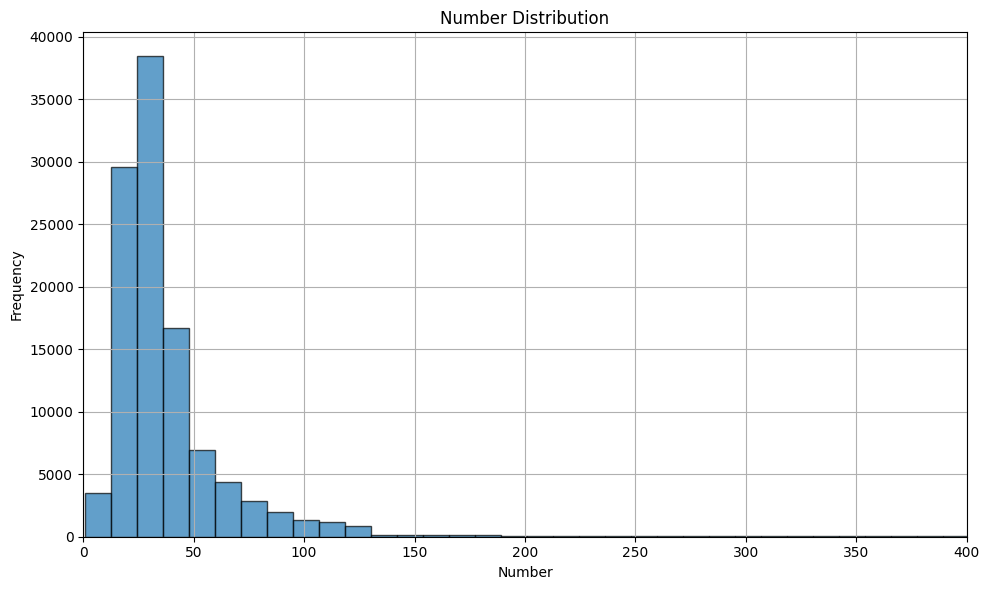

In [90]:
json_data = simcse_sorted

query_list = []
topic_list = []
for i in tqdm(range(len(json_data))):
    query_list.append(len(json_data[i]['query']))
    #topic_list.append(len(json_data[i]['topic']))
    

#visualize_number_distribution(topic_list)
visualize_number_distribution(query_list, lim=400)

# Scatter Plot

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [173]:
data_x = [x['rouge'] for x in simcse_sorted]
data_y = [x['simCSE'] for x in simcse_sorted]

In [9]:
output = first_confirms

In [10]:
threshold = 0.6
rouge_coef = 0.2


for i, data in enumerate(output):
    output[i]['harmonic'] = data['simCSE'] + data['rouge'] * rouge_coef
    output[i]['confirm'] = output[i]['harmonic'] >= threshold

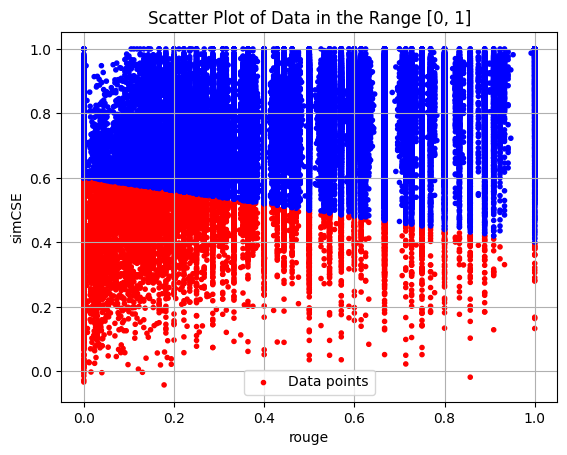

In [12]:
x_key = 'rouge'
y_key = 'simCSE'

data_x = [x[x_key] for x in output]
data_y = [x[y_key] for x in output]
data_color = ['b' if x['confirm'] else 'r' for x in output]

plt.scatter(data_x, data_y, marker='.', color=data_color, label='Data points')
#plt.axhline(0, color='r', linestyle= '-', label='Zero line')
plt.xlabel('rouge')
plt.ylabel('simCSE')
plt.title('Scatter Plot of Data in the Range [0, 1]')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
output

[{'query': '중립적인 입장을 피하고 독특한 관점에서 주제를 탐구하는 에세이를 작성하세요. 서론과 결론은 간결하게 작성하되, 풍부하고 다양한 어휘를 사용하여 주제의 각 측면을 동일한 깊이와 길이로 탐구하세요. 에세이의 길이는 약 250단어여야 합니다. 주제는 다음과 같습니다:    낡은 건물을 허물고 새 건물을 짓는 데 사용해야 할 돈을 수리하는 데 너무 많은 돈이 낭비되고 있습니다.    어느 정도 동의하시나요, 동의하지 않으시나요?',
  'topic': '낡은 건물 수리 비용 낭비',
  'rouge': 0.178,
  'simCSE': -0.042,
  'harmonic': -0.006400000000000003,
  'confirm': False},
 {'query': 'Describe as reporting live a current event in 3 lines, what is happening right now using the following tweets, with a focus on the term "di maria"  sourceText Time Di Maria scores the second goal for Argentina. 15:36:48.0000000 Argentinaaaaaaaaaaa ???? What A GOAL!!!!!! Angel Di Maria you beautyyyyyy #FIFAWorldCup #ArgentinaVsFrance 15:36:41.0000000 35\' GOAL ?\'\'Di Maria gets Argentina\'s second and France are torn apart on the counterattack!\'\'#ARG 2-0 #FRA \'\'#FIFAWorldCup | #Qatar2022 https://t.co/xQHVZ64vXA 15:36:57.0000000 2-0 for Argentina what a Goal!! Di Maria 15:36:52.0000000 Second goal by 

In [11]:
confirm = []

for i, data in enumerate(output):
    if data['confirm']:
        confirm.append(data)

In [185]:
len(confirm)

98770

In [12]:
confirm.sort(key=lambda x : x['harmonic'])
confirm

[{'query': '개인 뱅킹의 맥락에서 네트워크 보안이 중요한 이유를 설명하세요.',
  'topic': '네트워크 보안의 중요성',
  'rouge': 0.545,
  'simCSE': 0.491,
  'harmonic': 0.6,
  'confirm': True},
 {'query': '반지름이 5인 구의 표면적을 계산합니다.',
  'topic': '구의 표면적 계산',
  'rouge': 0.5,
  'simCSE': 0.5,
  'harmonic': 0.6,
  'confirm': True},
 {'query': 'isPassApplicable` 및 `calculateCoveredDuration` 함수를 코딩합니다.',
  'topic': 'Javascript 함수 코딩',
  'rouge': 0.5,
  'simCSE': 0.5,
  'harmonic': 0.6,
  'confirm': True},
 {'query': 'How do you manage your time according to nbti? Answer in English.번역 취소하기nbti에 따라 시간을 어떻게 관리합니까?영어로 대답하십시오.',
  'topic': '시간 관리 방법',
  'rouge': 0.16,
  'simCSE': 0.568,
  'harmonic': 0.6,
  'confirm': True},
 {'query': '텍스트가 아니라 작성자가 전달하고자 하는 메시지가 가장 좋은 버전이 무엇인지 고민합니다. 아무 말도 하지 않는 것도 유효한 옵션이지만 이것이 최선인지는 확실하지 않습니다.',
  'topic': '메시지 최적화',
  'rouge': 0.1,
  'simCSE': 0.58,
  'harmonic': 0.6,
  'confirm': True},
 {'query': '어떻게 해야 할지 모르겠어요. 도와주세요.',
  'topic': '도움 요청',
  'rouge': 0.0,
  'simCSE': 0.6,
  'harmonic': 0.6,
  'co